#MNIST digit recognition using Stochastic Gradient Boosting in **scikit-learn**

#> Use GridSearchCV to find optimal max_depth

In [1]:
from __future__ import division
import os, time, math
import cPickle as pickle

import matplotlib.pyplot as plt
import numpy as np
import csv

from sklearn.ensemble         import GradientBoostingClassifier

from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.grid_search      import GridSearchCV

from sklearn.metrics          import classification_report, confusion_matrix, f1_score
from sklearn.externals        import joblib

np.random.seed(seed=1009)

%matplotlib inline

In [2]:
#%qtconsole

##Where's the data?

In [3]:
file_path = '../data/'

DESKEWED = True
if DESKEWED:
    train_img_filename = 'train-images_deskewed.csv'
    test_img_filename  = 't10k-images_deskewed.csv'
else:
    train_img_filename = 'train-images.csv'
    test_img_filename  = 't10k-images.csv'
    
train_label_filename = 'train-labels.csv'
test_label_filename  = 't10k-labels.csv'

##How much of the data to use?

In [4]:
portion = 0.10  # set to 1.0 for all of it

##Read the training images and labels

In [5]:
with open(file_path + train_img_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
trainX = np.asarray(data, dtype = np.float64)  

trainX = trainX[:portion*trainX.shape[0]]

print("trainX shape: {0}".format(trainX.shape))

with open(file_path + train_label_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
trainY = np.asarray(data, dtype = np.int8) 

trainY = trainY[:portion*trainY.shape[0]].ravel()

print("trainY shape: {0}".format(trainY.shape))

trainX shape: (6000, 784)
trainY shape: (6000,)


#Read the test-set images and labels

In [6]:
with open(file_path + test_img_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
testX = np.asarray(data, dtype = np.float64)  

testX = testX[:portion*testX.shape[0]]

print("testX shape: {0}".format(testX.shape))

with open(file_path + test_label_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
testY = np.asarray(data, dtype = np.int8)

testY = testY[:portion*testY.shape[0]].ravel()

print("testY shape: {0}".format(testY.shape))

testX shape: (1000, 784)
testY shape: (1000,)


#Use the scikit smaller, fewer images for testing

##Function to print a matrix of images

In [7]:
def print_imgs(images, actual_labels, predicted_labels, starting_index = 0, size=6):
    """
    print a grid of images
    showing any differences in predicted values
    
    images           m x 784 array of pixels
    actual_lables    m x 1 array of the actual labels
    predicted_labels m x 1 of predicted labels
    starting_index   scalar, where in 1...m to start
    size             scalar the grid is size x size
    """
    img_dim  = int(pow(images.shape[1],0.5)) # images assumed to be square
    fig, axs = plt.subplots(size,size, figsize=(img_dim,img_dim), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = 0.0001, wspace=.001)
    axs = axs.ravel()
    
    for grid_i, img_i in enumerate(xrange(starting_index, starting_index+(size*size))):
        
        # convert from 1 x flat to img_dim x img_dim
        img = np.reshape(images[img_i,:],(img_dim,img_dim))
        
        axs[grid_i].imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
        
        if actual_labels[img_i] != predicted_labels[img_i]:
            axs[grid_i].set_title("actual: {0}; predicted: {1}" \
                                  .format(actual_labels[img_i], predicted_labels[img_i]), 
                                  fontsize=16,
                                  color='r')
        else:
            axs[grid_i].set_title("label: {0}" \
                                  .format(actual_labels[img_i]), 
                                  fontsize=16)
            
    plt.show()

##Print a sample

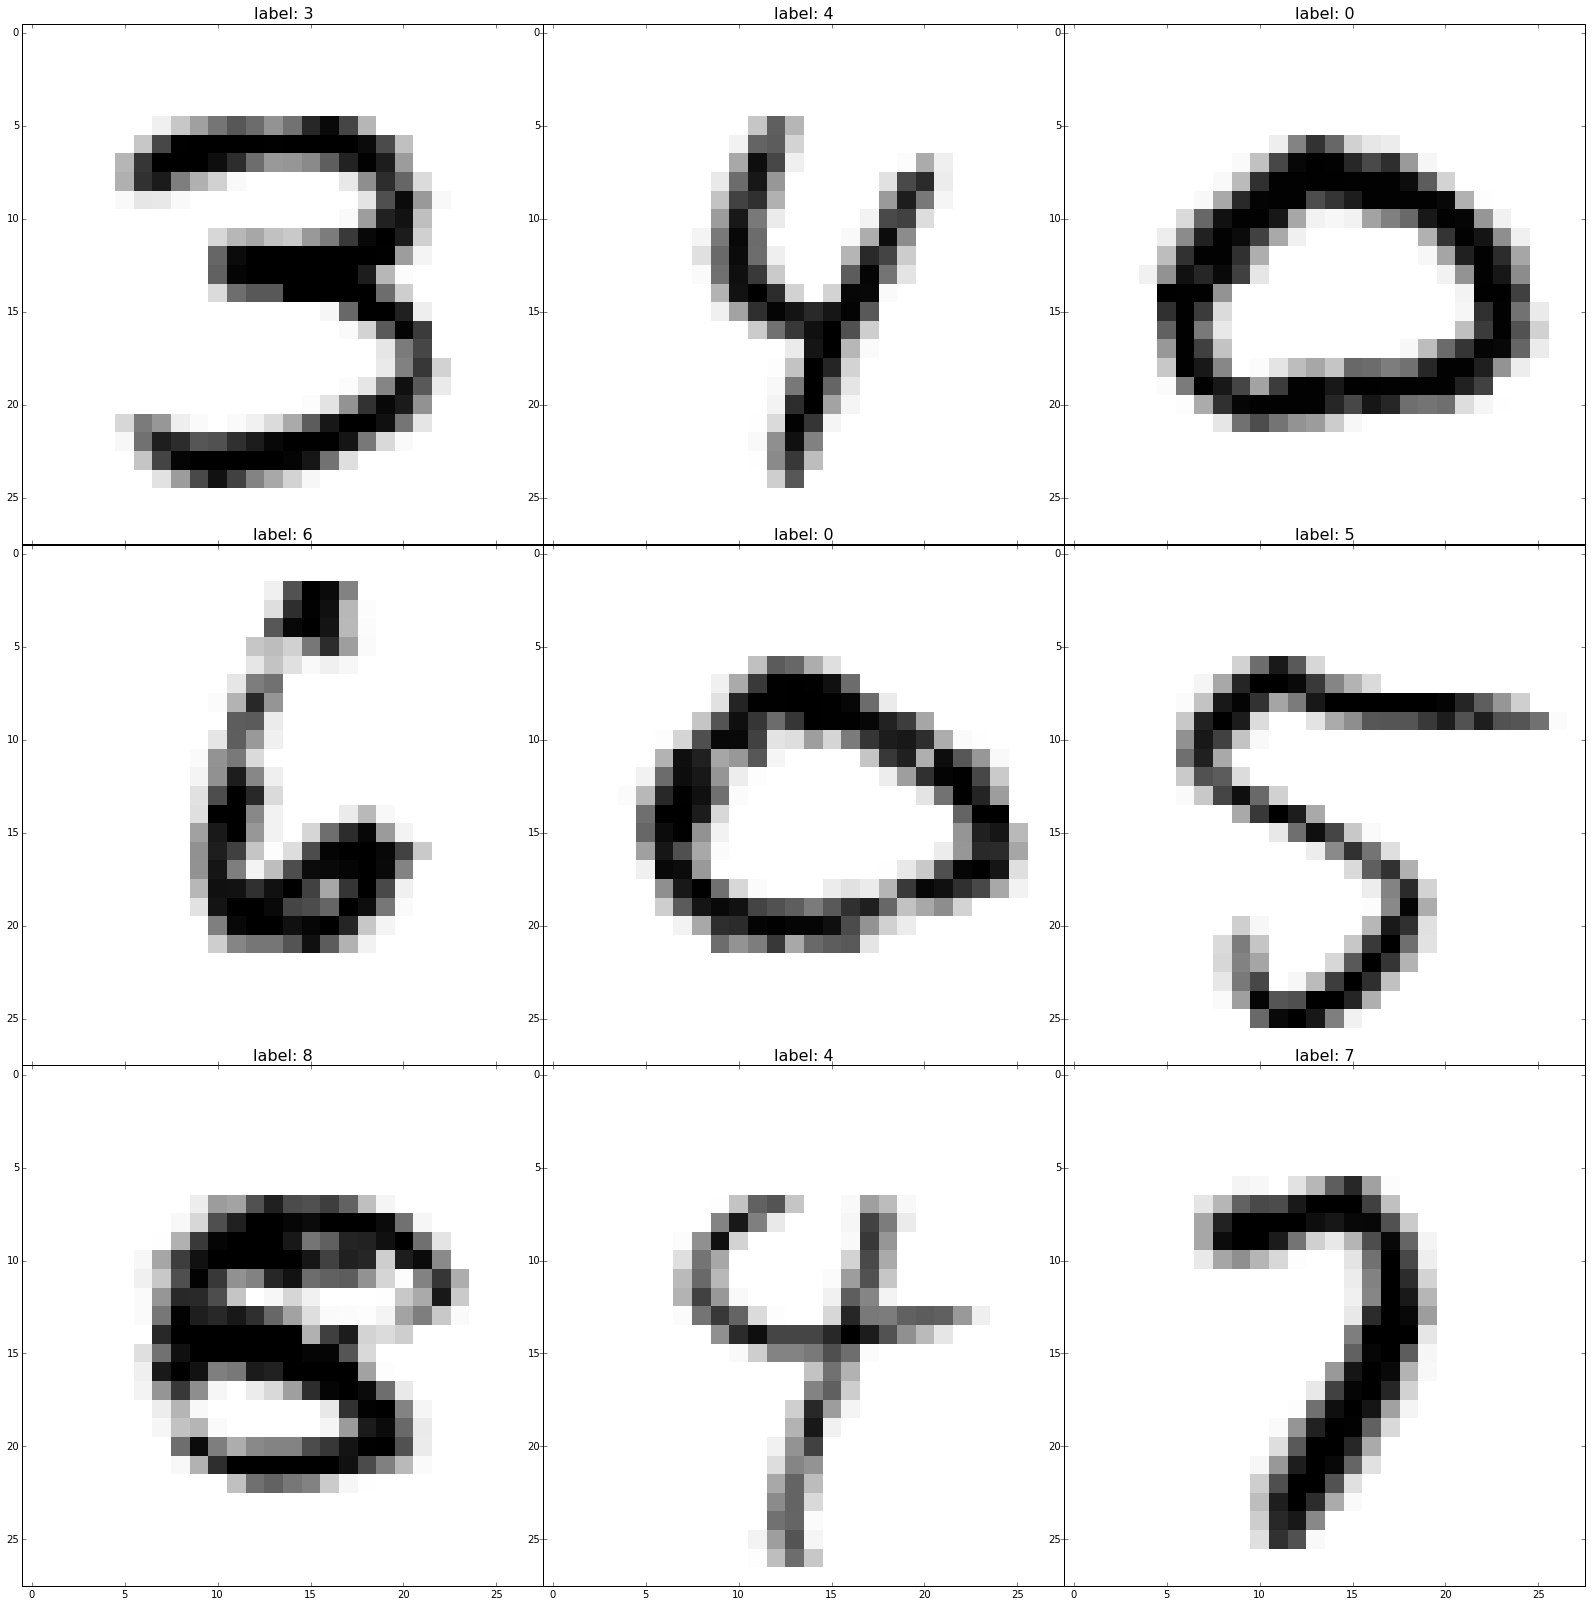

In [8]:
print_imgs(images           = trainX, 
           actual_labels    = trainY.ravel(), 
           predicted_labels = trainY.ravel(),#np.random.permutation(trainY), 
           starting_index   = np.random.randint(0, high=trainY.shape[0]-36, size=1)[0],
           size             = 3)

***
#Do a Grid-Search Cross-Validation to identify the best max_depth

##Set up the classifier

In [9]:
# default parameters for GradientBoostingClassifier
# =================================================
default_gbm_params = {}
default_gbm_params['loss'] = 'deviance'

default_gbm_params['learning_rate'] = 1 
default_gbm_params['n_estimators']  = 100 

default_gbm_params['max_depth']      = 3     # fix the tree size
default_gbm_params['max_leaf_nodes'] = None  # choose tree size by deviance reduction
                                             # Note: these two are mutually exclusive

default_gbm_params['subsample']    = 0.5     # stochastic by observations
default_gbm_params['max_features'] = None    # stochastic by columns (similar to random forest)

default_gbm_params['min_samples_split'] = 2 
default_gbm_params['min_samples_leaf']  = 1 
#default_gbm_params['min_weight_fraction_leaf'] = 0.0

default_gbm_params['init']         = None 
default_gbm_params['random_state'] = 1009    # set a random seed
default_gbm_params['verbose']      = 0 
default_gbm_params['warm_start']   = False

# set parameters for the estimator
gbm_params = dict(default_gbm_params)

# create the estimator
# ====================
gbm = GradientBoostingClassifier(**gbm_params)

##Perform the grid search

In [10]:
t0 = time.time()

# search grid
# ===========
ntrees    = np.array([1000])
maxdepth  = np.array([2,3,4,5,6,7])
learnrate = np.array([0.1])

search_grid = dict(n_estimators  = ntrees,
                   max_depth     = maxdepth,
                   learning_rate = learnrate)

# stratified K-Fold indices
# =========================
SKFolds = StratifiedKFold(y            = trainY.ravel(), 
                          n_folds      = 3, 
                          indices      = None, 
                          shuffle      = True, 
                          random_state = 1009)

# default parameters for GridSearchCV
# ===================================
default_grid_params = {}
default_grid_params['scoring']      = None       
default_grid_params['loss_func']    = None 
default_grid_params['score_func']   = None       
default_grid_params['fit_params']   = None       # dict of parameters to pass to the fit method

default_grid_params['n_jobs']       = -1         # -1 => use all available cores
                                                 #       one core per fold
                                                 #       for each point in the grid
default_grid_params['pre_dispatch'] = '2*n_jobs' # memory is copied this many times
                                                 # reduce if you're running into memory problems
    
default_grid_params['iid']          = True       # assume the folds are iid 
default_grid_params['refit']        = True       # Refit the best estimator with the entire dataset 
default_grid_params['cv']           = SKFolds 
default_grid_params['verbose']      = 0 
#default_grid_params['error_score']  = np.NaN ... parameter rejected

# set parameters for the grid search
grid_params = dict(default_grid_params)


# perform the parameter grid search
# =================================
grid_search = GridSearchCV(estimator = gbm, param_grid = search_grid, **grid_params)

grid_search.fit(trainX, trainY.ravel())

print(grid_search)

import cPickle as pickle
# save the model to disk
# ======================
if os.path.isdir('model'):
    !rm -r model

!mkdir model
pickle.dump( grid_search, open( "model/gbm_GridSearchCV.pkl", "wb" ) )

print("\ntime in minutes {0:.2f}".format((time.time()-t0)/60))

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[5 0 ..., 6 9], n_folds=3, shuffle=True, random_state=1009),
       estimator=GradientBoostingClassifier(init=None, learning_rate=1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2, n_estimators=100,
              random_state=1009, subsample=0.5, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'n_estimators': array([1000]), 'learning_rate': array([ 0.1]), 'max_depth': array([2, 3, 4, 5, 6, 7])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

time in minutes 56.53


##Look at the best parameters found

In [11]:
clf = pickle.load( open( "model/gbm_GridSearchCV.pkl", "rb" ) )

print(clf.best_estimator_)
print(clf.best_score_)
print(1-clf.best_score_)
print(clf.best_params_)

GradientBoostingClassifier(init=None, learning_rate=0.10000000000000001,
              loss='deviance', max_depth=4, max_features=None,
              max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
              n_estimators=1000, random_state=1009, subsample=0.5,
              verbose=0, warm_start=False)
0.944166666667
0.0558333333333
{'n_estimators': 1000, 'learning_rate': 0.10000000000000001, 'max_depth': 4}


##Predict the test set and Analyze the result

In [12]:
target_names     = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

predicted_values = clf.predict(testX)
y_true, y_pred   = testY.ravel(), predicted_values

print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98        85
          1       1.00      0.98      0.99       126
          2       0.90      0.94      0.92       116
          3       0.97      0.89      0.93       107
          4       0.95      0.95      0.95       110
          5       0.93      0.91      0.92        87
          6       0.95      0.92      0.94        87
          7       0.92      0.94      0.93        99
          8       0.88      0.94      0.91        89
          9       0.92      0.90      0.91        94

avg / total       0.94      0.94      0.94      1000



[[ 85   0   0   0   0   0   0   0   0   0]
 [  0 124   0   0   0   0   1   0   1   0]
 [  0   0 109   1   0   0   1   3   2   0]
 [  0   0   2  95   0   5   0   1   2   2]
 [  0   0   1   0 105   0   1   0   1   2]
 [  1   0   0   1   2  79   1   1   1   1]
 [  3   0   3   0   0   1  80   0   0   0]
 [  0   0   3   0   2   0   0  93   0   1]
 [  0   0   3   1   0   0   0   0  84   1]
 [  0   0   0   0   2   0   0   3   4  85]]

Model accuracy: 0.939, model misclass rate: 0.061


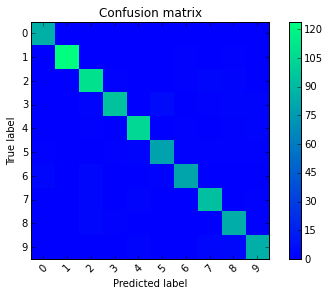

In [13]:
def plot_confusion_matrix(cm, 
                          target_names,
                          title='Confusion matrix', 
                          cmap=plt.cm.winter):  
    """
    given a confusion matrix (cm), make a nice plot
    see the skikit-learn documentation for the original done for the iris dataset
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(y_true, y_pred)  

print(cm)
model_accuracy = sum(cm.diagonal())/len(testY)
model_misclass = 1 - model_accuracy
print("\nModel accuracy: {0}, model misclass rate: {1}".format(model_accuracy, model_misclass))

plot_confusion_matrix(cm, target_names)